In [1]:
import sys

sys.path.insert(1, '..')
from custom_functions import ModelFunctions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, accuracy_score, classification_report



In [3]:
df = pd.read_csv('../data/features.csv')

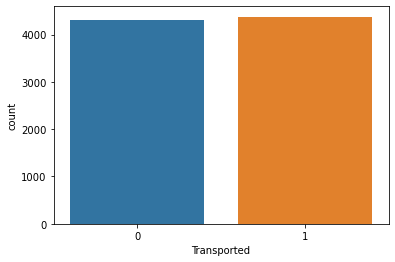

In [4]:
sns.countplot(data=df, x='Transported');

In [5]:
X = df.drop(['Transported'], axis=1)
y = df.Transported

In [6]:
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupBool,HomePlanet_Europa,...,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S,CabinGroup_Group 2,CabinGroup_Group 3,CabinGroup_Group 4,CabinGroup_Group 5
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0,0,1,0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,0,0,...,0,0,0,1,0,1,0,0,1,0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [7]:
X.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'GroupBool', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'CabinDeck_B',
       'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F',
       'CabinDeck_G', 'CabinDeck_T', 'CabinSide_S', 'CabinGroup_Group 2',
       'CabinGroup_Group 3', 'CabinGroup_Group 4', 'CabinGroup_Group 5'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Default Models

In [8]:
import imp
imp.reload(ModelFunctions)

<module 'custom_functions.ModelFunctions' from 'c:\\Users\\61411\\kaggle_comps\\spaceship-titanic\\notebooks\\..\\custom_functions\\ModelFunctions.py'>

In [9]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Classification Report for: LR
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1289
           1       0.77      0.82      0.80      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Classification Report for: DT
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1289
           1       0.75      0.74      0.74      1319

    accuracy                           0.74      2608
   macro avg       0.74      0.74      0.74      2608
weighted avg       0.74      0.74      0.74      2608

Classification Report for: RF
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1289
           1       0.82      0.77      0.79      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80     

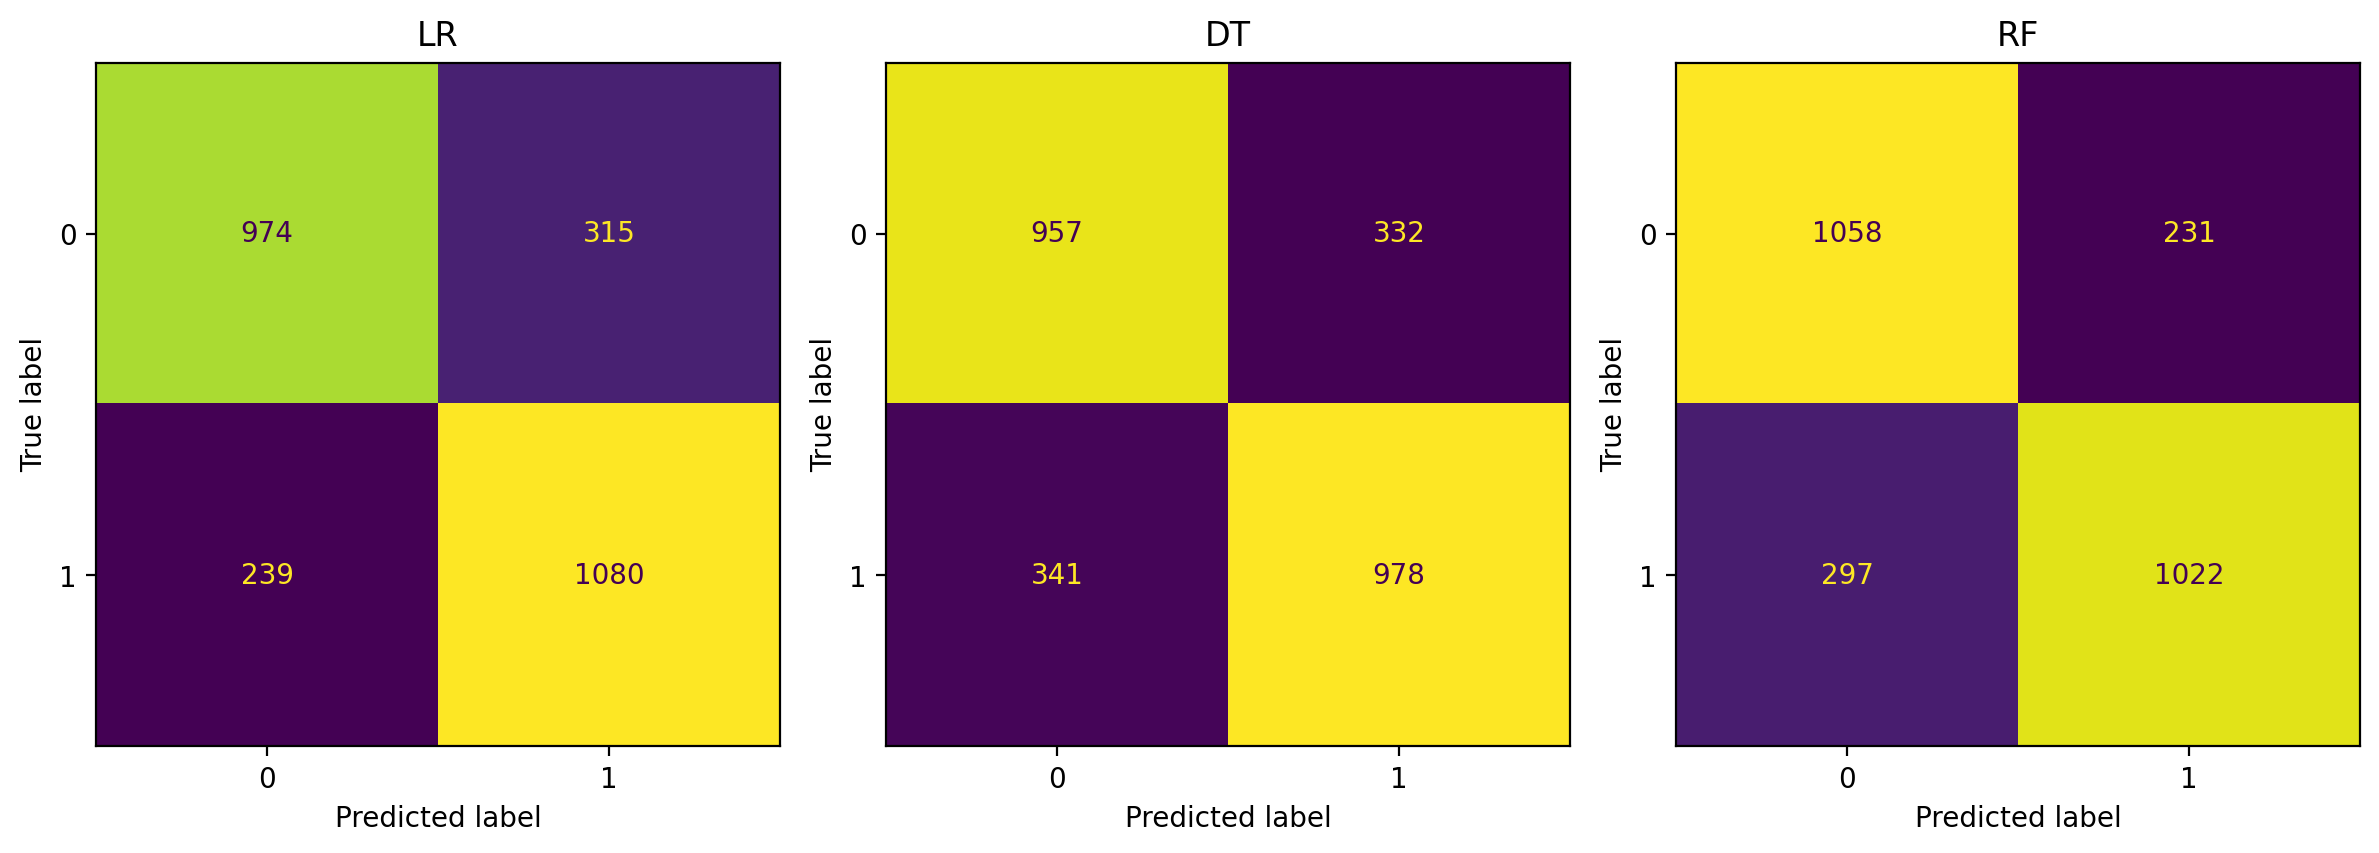

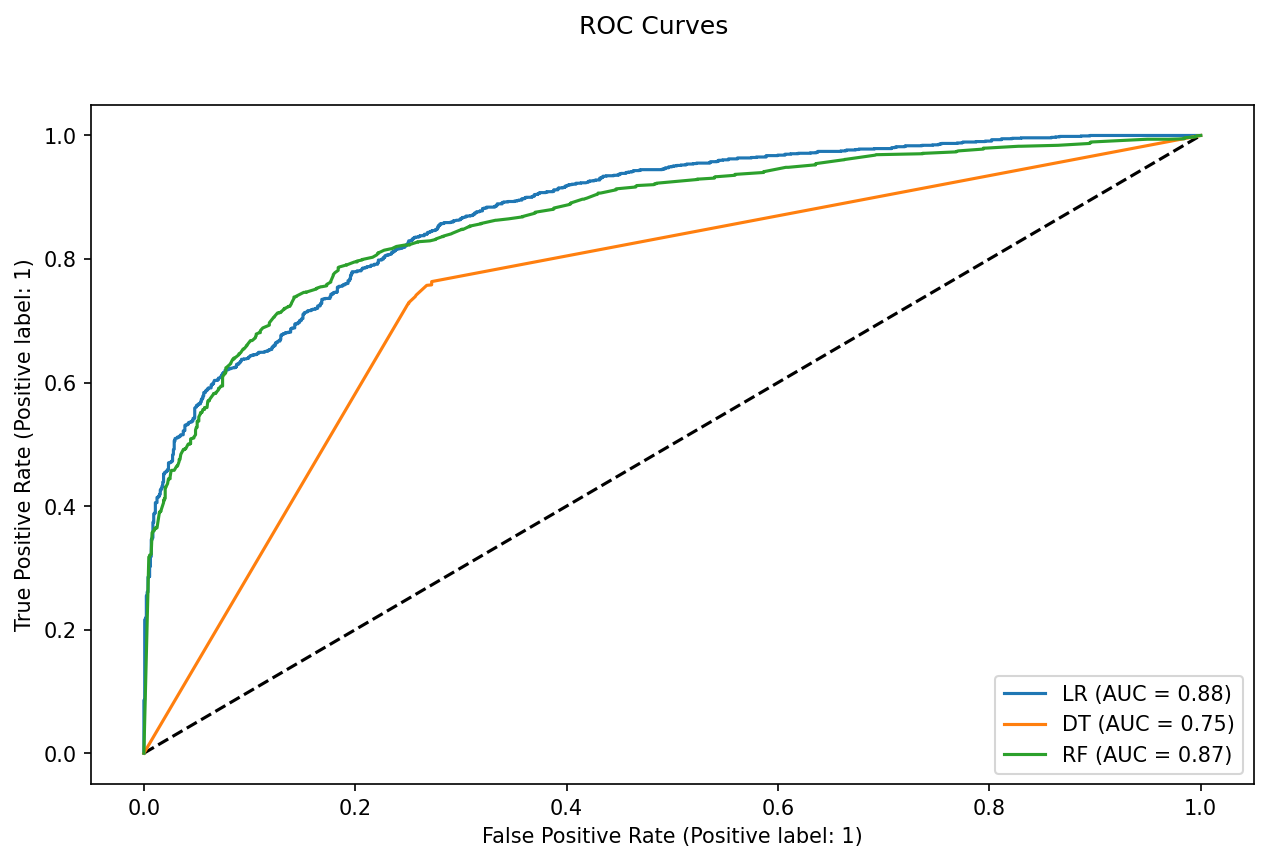

In [10]:
models = {
    'LR': LogisticRegression().fit(scaled_X_train, y_train),
    'DT': DecisionTreeClassifier().fit(scaled_X_train, y_train),
    'RF': RandomForestClassifier().fit(scaled_X_train, y_train)
}

ModelFunctions.show_all_metrics(models, scaled_X_test, y_test)

In [11]:
# TODO: build a simple end-to-end pipeline
# TODO: Investigate the Group size feature in EDA
# TODO: Evalute 3 models: Logistic Regression, DecisionTree, and SVClassifier

We quickly sees that the default logistic regression model with L2 regularization and standardized features has the best performance out of the three models. For now, we'll quickly build an end-to-end pipeline to submission of predictions to Kaggle.

In [12]:
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupBool,HomePlanet_Europa,...,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S,CabinGroup_Group 2,CabinGroup_Group 3,CabinGroup_Group 4,CabinGroup_Group 5
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0,0,1,0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,0,0,...,0,0,0,1,0,1,0,0,1,0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [13]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

pipe.fit(X, y)

from joblib import dump
dump(pipe, '../models/simple_model.joblib')

['../models/simple_model.joblib']